# **Project 9: Analyzing Influence of Global Oscillations on PNW Snow**

From the start of this project, I knew that I wanted to investigate some type of weather pattern in Seattle. I have been obsessed with forecasting snow in Seattle since middle school. During high school, I spent most of my free time forecasting the weather and communicating online with other enthusiasts. One tool I often used are teleconnections (oscillations), which are measurements of repeating climate patterns in specific places. For example, the El Nino Southern Oscillation (ENSO) is based on a pattern of changes in sea surface temperatures and sea level atmospheric pressure in the Equatorial Eastern Pacific, oscillating every few years and influencing seasonal trends in weather across the US.

For this project, I decided to analyze how each common oscillation I use in forecasting correlates to snow in Seattle, including:
*   Pacific North American Oscillation (PNAO)
*   North Atlantic Oscillation (NAO)
*   Antarctic Oscillation (AAO)
*   Arctic Oscillation (AO)
*   El Nino Southern Oscillation (ENSO)

I also attempted to answer a question I have had about Seattle snowfall trends: what is the most common month for snowfall and how is that changing over time?


Data-driven Questions:

*   Which oscillation is most closely correlated with monthly changes in Seattle snowfall?
*   Which oscillation is most closely correlated with yearly changes in Seattle Snowfall?
*   How has the distribution of snow over the course of a year changed over time?

**Importing Packages:**

In [377]:
def makeChart(xlabel,ylabel,title):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

In [378]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt

# Linear regression
from sklearn.linear_model import LinearRegression
import numpy as np

# Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Part 1: Loading Data**

To answer my data questions, I needed to collect historical data for each oscillation and for Seattle snowfall. I used two sources for this:

*   The [Climate Prediction Center](https://ftp.cpc.ncep.noaa.gov/cwlinks/) for oscillation data
   *   ASCII txt files for each oscillation
*   ENSO data was not available along with the other oscillations, so I sourced it from NOAA's [Physical Sciences Laboratory](https://psl.noaa.gov/data/timeseries/month/DS/MEIV2/).
   *   There are multiple ways of measuring ENSO: I used the Multivariate ENSO Index (MEI V2) that combines metrics for the most comprehensive measurement of the oscillation.
*   The National Centers for Environmental Information's [data portal](https://www.ncei.noaa.gov/cdo-web/) for Seattle snowfall data.
   *   Requested a CSV file of daily snowfall data
   *   NOAA CDO is an incredible resource for U.S. weather data. It contains data for any official weather station as well as larger geographical places and areas, with a vast selection of timesteps and data types.

This method of data collection is vastly simpler than, say, using an API, but weather data is quite accessible in general and I saw no need to overcomplicate this part of the project.




Once I received all of these datafiles, I prepared and loaded them into dataframes. To do this, I made a function to repeat the process of reading the oscillation txt files into a dataframe. The files used space characters as separators, so I specified that one or more spaces separated entries. I ignored the headers and reformatted with names I preferred.

The ENSO data was sourced separately as a CSV, so turning it into a dataframe was very simple.

In [379]:
project = "/content/drive/MyDrive/CS215/Project 9/"

# Function to make dataframes from ASCII txt files for each oscillation
def make_df(file, osc):
  return_file = pd.read_table(project+file, sep=r"\s+", header=None, names=['year', 'month', osc])
  return(return_file)


# El Nino Southern Oscillation:
# File sourced differently as a csv. Last 9 rows skipped for unrecorded months
# of 2025. Ignored and deleted title column and replaced names. skipfooter
# required using the 'python' engine.
df_monthly_enso = pd.read_csv(project+"enso_monthly.csv", names=['date', 'enso'], skipfooter=9, skiprows=1, engine='python')

# Pacific North American Oscillation:
df_monthly_pnao = make_df('monthly_pna.txt', 'pnao')

# Northern Atlantic Oscillation:
df_monthly_nao = make_df('monthly_nao.txt', 'nao')

# Antarctic Oscillation:
df_monthly_aao = make_df('monthly_aao.txt', 'aao')

# Arctic Oscillation:
df_monthly_ao = make_df('monthly_ao.txt', 'ao')

# Seattle snowfall data:
df_snow = pd.read_csv(project+'snow.csv')

In [380]:
# Dictionary of oscillation strings and the corresponding dataframes for
# reference in loops, functions, etc.
oscillations = {'pnao':df_monthly_pnao, 'enso':df_monthly_enso, 'nao':df_monthly_nao, 'aao':df_monthly_aao, 'ao':df_monthly_ao}

# **Part 2: Wrangling and Analysis**


For this project, I decided that the most effective way to assess the correlation between oscillations and snowfall was through linear regression analysis. I have not taken statistics, so I had to do a lot of research into the libraries and types of regression analysis available. I settled on using an ordinary least squares (OLS) linear regression so as not to end up in a rabbit hole outside of my mathematical comfort zone. I ended up using scikit-learn for its streamlined and simple use methods. I performed this analysis with the snowfall data and each oscillation to see how well correlated changes in snow and oscillations are.


Before I could do this analysis, I had to consolidate my data into a table with the same timesteps.

First, I started creating a monthly dataframe by grouping snow by month. I first downloaded daily snowfall data with the intention of doing this analysis by day, but oscillation values are monthly.

In [381]:
# Convert to datetime
df_snow['DATE'] = pd.to_datetime(df_snow['DATE'])

# Define new year and month columns
df_snow['year'] = df_snow['DATE'].dt.year
df_snow['month'] = df_snow['DATE'].dt.month

# Groupby year and month to get a monthly snowfall table
monthly_snowfall = df_snow.groupby(['year', 'month'])['SNOW'].sum().reset_index()
yearly_snowfall = df_snow.groupby(['year'])['SNOW'].sum().reset_index()

# New DF
df_monthly = monthly_snowfall
df_yearly = yearly_snowfall

I formatted the ENSO dataframe to include year and month columns like the other oscillation dataframes.

In [382]:
# Add month and year columns to enso
df_monthly_enso['date'] = df_monthly_enso['date'].astype(str)
df_monthly_enso['year'] = df_monthly_enso['date'].str[:4].astype(int)
df_monthly_enso['month'] = df_monthly_enso['date'].str[5:7].astype(int)

**Monthly Analysis:**

To answer how monthly snowfall changes are explained by oscillations, I performed the first part of the analysis with monthly data.

To start, I merged each oscilation dataframe into the monthly dataframe with a for loop, using an inner join to ensure the data timeframes lined up. The dataset for ENSO started in 1979, so I limited the oscillation data to this timeframe as well.

In [383]:
# Merge oscillation and snow dataframes into one monthly dataframe using an inner join
df_monthly_osc = df_monthly.copy()
for osc in oscillations.values():
  df_monthly_osc = pd.merge(df_monthly_osc, osc, on=['year', 'month'], how='inner')

Using the scikit-learn OLS linear regression model, I calculated r^2 values for each oscillation. scikit requires a 2d array for linear regression, so x is selected as a dataframe with the oscillation values. I calculated the best fit line of the data for use in the bar chart. I multiplied these values by 100 to represent the % correlation to snowfall changes. Finally, I made a simple bar chart to display the results of the analysis for each oscillation.

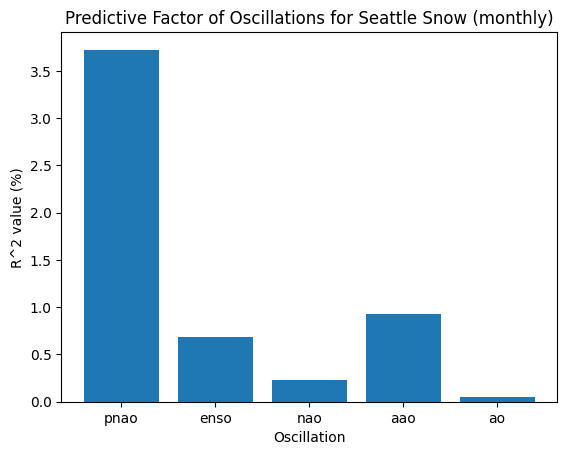

In [384]:
# Dictionary to store r^2 values
r_values = {}

# Perform LR analysis for each oscillation
for osc in oscillations.keys():
    x = df_monthly_osc[[osc]].values
    y = df_monthly_osc['SNOW'].values
    model = LinearRegression().fit(x, y)
    r_values[osc] = model.score(x, y)
    r_values[osc] *= 100

# Pyplot bar chart comparison of regression analysis of oscillations
plt.bar(r_values.keys(), r_values.values())
makeChart('Oscillation', 'R^2 value (%)', 'Predictive Factor of Oscillations for Seattle Snow (monthly)')

The results of this analysis were better than I had expected, and make sense compared to my experience forecasting snow. I had expected ENSO to have a stronger correlation than it does. After thinking about the results, I realized that the ENSO oscillates on a longer timescale than the other oscillations (especially the PNAO), meaning that it won't explain month-to-month changes in snowfall as well. In contrast, the PNAO oscillates quite frequently, leading to a stronger correlation on a monthly level. Interestingly, the Antarctic Oscillation had a much stronger correlation than the Arctic oscillation, despite being much more distant to Seattle. I am not sure why this is; a further analysis project could gain insight into this result.

**Yearly Analysis:**

I used similar methods to do the yearly analysis, grouping by year. I averaged oscillation values for each year to get the overall value for that year.

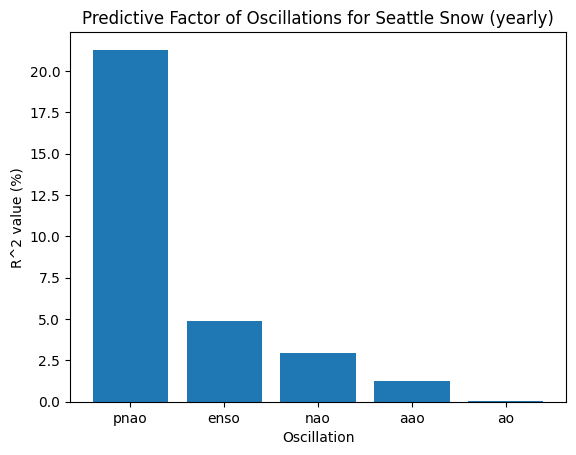

In [385]:
# Dictionary to store r^2 values
r_values_yearly = {}

# Copy to avoid accidental modification
df_yearly_merged = df_yearly.copy()

# Properly group and analyze each oscillation
for osc, df in oscillations.items():
  # Copy of each oscillation inside each iteration to avoid accidental modification
  osc_yearly = df.copy().groupby(['year'])[osc].mean().reset_index()
  df_yearly_merged = pd.merge(df_yearly, osc_yearly, on=['year'], how='inner')

  # OLS analysis
  x2 = df_yearly_merged[[osc]].values
  y2 = df_yearly_merged['SNOW'].values
  model = LinearRegression().fit(x2, y2)
  r_values_yearly[osc] = model.score(x2, y2)
  r_values_yearly[osc] *= 100

# Pyplot bar chart comparison of regression analysis of oscillations
plt.bar(r_values_yearly.keys(), r_values_yearly.values())
makeChart('Oscillation', 'R^2 value (%)', 'Predictive Factor of Oscillations for Seattle Snow (yearly)')

Overall, these results are fairly similar to the monthly analysis. Almost all of the oscillations have much stronger correlations to Seattle snowfall. In Seattle, snowfall is infrequent enough that analyzing it on a monthly level will have a limited amount of useful data that can be tied to changes in oscillations. On a yearly level, oscillations can have a more consistent effect. If there is a strong La Nina trend on the ENSO one year, the climate in the PNW is consistently cooler and wetter. When looking at monthly changes, there will often be one snow event at best in winter months, which will lead to much more randomness in the factors behind that snow.

The only change in the yearly analysis is that the NAO has a higher R^2 value than the AAO. This change would also require further analysis to understand.

**Changes in most common months for snow**

For the last part of my analysis, I wanted to answer a question I have had while forecasting snow in Seattle over the years: what are the most common months for snow, and how are they changing? Myself and other people I talk about the weather with have anecdotally noticed that it seems to be snowing in February more than it used to, with January receiving less.

To answer this, I divided my snow dataset into two sections and plotted the average yearly distribution of snow for each of these sections in a line chart. I spent an absurdly long time trying to answer this question using joyplots and then offset line charts that imitated a joyplots. This ended up being so complicated to learn and implement that I had to abandon it. I also realized that I could answer the question using a fairly simple line plot. In addition, a joyplot would likely end up failing to show any readable or useful information because of the sparseness of snow data for Seattle.

First, I split the dataset into two halves. Then, I grouped these halves by month with the average snow value for that month.

In [386]:
# Copy of the monthly dataset to avoid accidental modification
df_line = df_monthly.copy()

# Create a new column for name of month by using python's map() function. This
# works by assigning the appropriate dictionary key to the value in the dataframe
# that matches the dictionary value.
month_dict = {1: 'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}
df_line['month_name'] = df_line['month'].map(month_dict)

# Define halves
early_years = [i for i in range(1979,2002)]
later_years = [i for i in range(2002,2025)]

# Group each half by average monthly snow value over the dataset. reset_index
# makes month and month_name callable again.
early_df = df_line[df_line['year'].isin(early_years)].groupby(['month', 'month_name'])['SNOW'].mean().reset_index()
later_df = df_line[df_line['year'].isin(later_years)].groupby(['month', 'month_name'])['SNOW'].mean().reset_index()


I created a simple line plot of the two halves using pyplot.

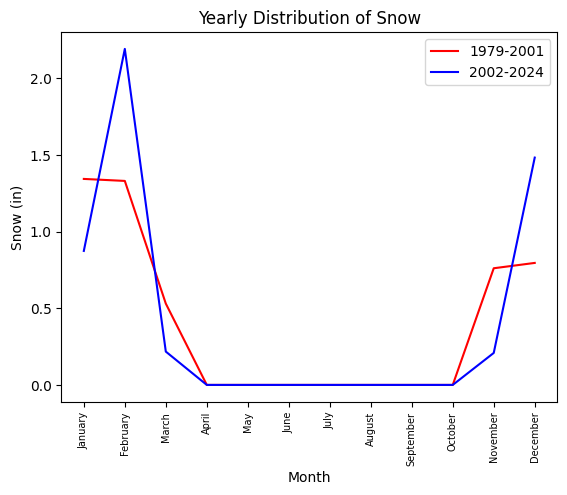

In [387]:
plt.plot(early_df['month_name'], early_df['SNOW'], color='red', label='1979-2001')
plt.plot(later_df['month_name'], later_df['SNOW'], color='blue', label='2002-2024')
plt.xticks(rotation=90, fontsize=7)
plt.legend()
makeChart('Month', 'Snow (in)', 'Yearly Distribution of Snow')

The result confirms what I have noticed: it is snowing more in February on average than it used to. January and November are receiving less snow than they used to. In the second half of my dataset, December and February are strongly favored for snow, as opposed to a more even distribution over winter months in the first half of the dataset.

# **Summary**


Through this project, I was able to learn which climate oscillations are most effective for predicting snowfall in Seattle and answer one of my long-standing questions about how snow is changing over time. This information will help me to become better at forecasting and improve my understanding of winter weather in Seattle.

# **Sources**

In addition to the hyperlinks mentioned throughout this notebook, I used NOAA's educational pages about the climate oscillations I used.

I also used the documentation pages for Seaborn, pyplot, joypy, and scikit-learn.

I used AI tools to help me learn about linear regression, as well as how to use scikit-learn to implement this in python. I never used AI to directly write code into the notebook. At times, I followed strategies outlined by AI, so I used a function that it suggested after I learned about it on my own. Each time I used AI, I made sure that I understood the libraries, methods, etc. that I used based on its suggestions before I used it in my code.

AI tools:


*   ChatGPT
*   Gemini
*   DeepSeek

